# Aplicación de librerías sklearn en la resolución de pronósticos
## Este resolución fue preparada utilizando la publicación de Joaquín Amat Rodrigo

Skforecast: forecasting series temporales con Python y Scikitlearn by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py27-forecasting-series-temporales-python-scikitlearn.html


    

## Acceso a las librerías que se utilizarán en la resolución.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

## Descarga de archivo CSV:
Venta de pasajes Enero 1949 a Dic 1960

In [2]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/mfsanchez2020/Pronosticos/main/AirPassengers5.csv'
datos = pd.read_csv(url, sep=',')
#datos = pd.read_csv('C:/Users/11818/.spyder-py3/db/AirPassengers5.csv')
print (datos)


          fecha    y  exog_1  exog_2
0    01-01-1949  112       1       1
1    02-01-1949  118       1       1
2    03-01-1949  132       1       1
3    04-01-1949  129       1       1
4    05-01-1949  121       1       1
..          ...  ...     ...     ...
139  08-01-1960  606       1       1
140  09-01-1960  508       1       1
141  10-01-1960  461       1       1
142  11-01-1960  390       1       1
143  12-01-1960  432       1       1

[144 rows x 4 columns]


## Preparación de los datos:
Se da formato de fecha a la columna fecha (en la importación es un string, hay que transformalo en tipo fecha)<br>
Se crea un indice sobre la fecha y se ordena por dicho indice.
Se indica que se utilizará una frecusncia mensual 'MS'

In [3]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'])
#, format='%y/%m/%d')
datos = datos.set_index('fecha')
#datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

,y,exog_1,exog_2
fecha,,,
1949-01-01,112,1,1
1949-02-01,118,1,1
1949-03-01,132,1,1
1949-04-01,129,1,1
1949-05-01,121,1,1


## Verificaciones de que el archivo está listo para ser procesado:
Verifica que todas las filas tenga datos.      --> Debe indicar que hay 0 filas sin valores. <br>
Verifica que el indice temporal esté completo. --> Debe indicar True <br>

In [4]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()
# Completar huecos en un índice temporal - Se usa si el indice temporal no está completo.
# ==============================================================================
#datos.asfreq(freq='MS', fill_value=np.nan)

Número de filas con missing values: 0.0


True

## Visualizción de los datos de la serie que se va a procesar

Fechas : 1949-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=144)


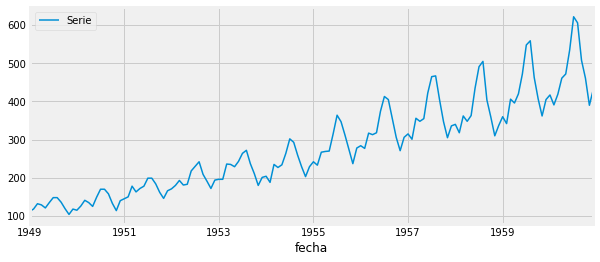

In [5]:
# Datos de la serie
# ==============================================================================
print(f"Fechas : {datos.index.min()} --- {datos.index.max()}  (n={len(datos)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos['y'].plot(ax=ax, label='Serie')
ax.legend();

## Preparación de datos para entrenamiento y testeo
<b>'usar'</b> indica la cantidad de meses que se utilizarán para testeo y entrenaiento. Se xpresa en 12 meses por x años por comodidad.<br>
Esta es una serie de muchos años, y parecerían que los prineros ya no representan el comportamiento presente con lo cual se crea esta variable para controlar que meses se quieren utilizar.<br> Veran que modificando estos meses se obtienen curvas y consecuentemente pronósticos diferente.<br>
<b>'steps'</b> indica los meses que se seleccionan para testeo. En este caso seleccione 12 meses.
Con esto se obtienen tres set de datos, el de entrenamiento (datos_train), el de testeo (datos_test) y la suma de estos dos (datos_select) 

Fechas train : 1954-01-01 00:00:00 --- 1959-12-01 00:00:00  (n=72)
Fechas test  : 1960-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=12)
Fechas final  : 1954-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=84)


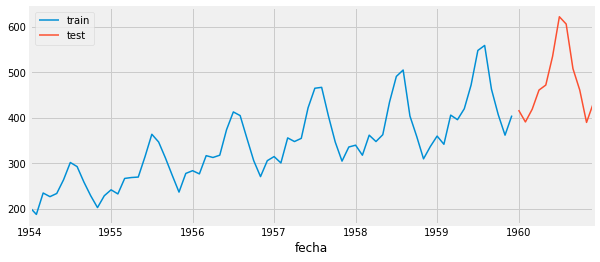

In [6]:
# Separación datos train-test
# ==============================================================================
usar = 12*7
steps = 12
datos_train = datos[-usar:-steps]
datos_test  = datos[-steps:]
datos_select = datos[-usar:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")
print(f"Fechas final  : {datos_select.index.min()} --- {datos_select.index.max()}  (n={len(datos_select)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
#datos_final['y'].plot(ax=ax, label='final')
ax.legend();

## Entrenamiento del predictor:
Las siguientes líneas utilizando el método ForecasterAutoreg de sklearn para entrenar al predictos.<br>
Se utiliza el parametro 'lags' que indica la cantidad de datos de la serie que forman la matriz de entrenamiento.
Para serie de datos con estacionalidad, es conveniente utilizar para este parámetro los períodos que contienen cada ciclo de estacionalidad, en nuestro ejemplo 12.
El metodo ForecasterAutoreg tiene otros parametros para su funcionamiento, aquí esos otros parametros se ejecutan en sus valores por defecto, mas adelante veremos un metodo para buscar esos parametros.<br>

In [7]:
## Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 12
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window size: 12 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1954-01-01 00:00:00'), Timestamp('1959-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-27 09:07:55 
Last fit date: 2022-08-27 09:07:55 
Skforecast version: 0.4.2 

## Generación del pronóstico.
Ya con el predictor entrenado en el paso anterior, pedimos que se genere la serie de valores futuros.<br>
steps = 12 indica que se quieren obtener prediciones para doce meses (uede cambiarse y pedirse predicciones para un período mayor)

In [8]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(steps)

1960-01-01    411.42
1960-02-01    385.51
1960-03-01    459.29
1960-04-01    451.64
1960-05-01    473.49
1960-06-01    522.27
1960-07-01    537.16
1960-08-01    535.40
1960-09-01    518.19
1960-10-01    473.17
1960-11-01    424.39
1960-12-01    469.55
Freq: MS, Name: pred, dtype: float64

## Grafico de la serie de pronosticada.

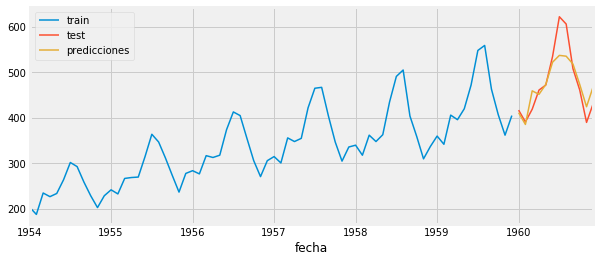

In [9]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();


## Calculo de los errores de la serie pronosticada
Se lo realiza comparando los valores pronosticados con la serie de testeo que reservamos. <br>
Se utilizan los 3 errores clásicos. <br>
<b>MAP</b>  (aquí se llama MAE mean absolute error) <br>
<b>MAPE</b> (que es la visión porcentual del error anterior) <br>
<b>MSE</b>  (error quadrático medio) <br>

In [10]:
# Error test
# ==============================================================================
error_mae = round(mean_absolute_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),2)

error_mape = round(mean_absolute_percentage_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ) * 100,2)

error_mse = round(mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),2)

print(f"Error de test (MAD): {error_mae}")
print(f"Error de test (MAPE): {error_mape} %")
#print('Error de test (MAPE) %i :' %(round(error_mape,2)))
print(f"Error de test (MSE): {error_mse}")

Error de test (MAD): 27.06
Error de test (MAPE): 5.38 %
Error de test (MSE): 1413.6


## Punto de control
En este punto hemos entrenado, pronosticado, graficado y calculado el error del pronóstico obtenido.<br>
Si el resultado es satisfactorio, se puede proceder a pronosticar los valores del siguiente año.<br>
Para ello vamos a re-entrenar al predictor pero ahora utilizando toda la serie de datos (la de training + la de testeo) en la serie que creamos al inicio en la preparación de los datos con el nombre de (datos_selec)<br>
Los tres bloques a continuación hacen el entrenamiento, la predicción y luego el gríafico correspondiente.<br>

In [11]:
## Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 12
             )

forecaster.fit(y=datos_select['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window size: 12 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1954-01-01 00:00:00'), Timestamp('1960-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-08-27 09:07:56 
Last fit date: 2022-08-27 09:07:56 
Skforecast version: 0.4.2 

In [12]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)
predicciones.head(12)

1961-01-01    455.60
1961-02-01    444.53
1961-03-01    461.41
1961-04-01    521.78
1961-05-01    560.52
1961-06-01    594.07
1961-07-01    598.37
1961-08-01    589.82
1961-09-01    577.64
1961-10-01    524.22
1961-11-01    445.08
1961-12-01    462.75
Freq: MS, Name: pred, dtype: float64

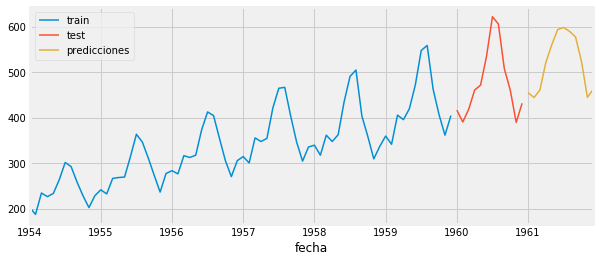

In [13]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## Busqueda de parametros para el entrenamiento
La librería sklearn tiene un metodo que permite buscar cuales son los parametros mas aecuados para el entrenamiento.<br>
Las siguientes lineas de código piden que se evaluen lags de 12 (lags_grid), estimadores en 50, 100 y 200 y max_depth de 3, 6 y 9.<br>
Mi exploración indica que para series con periodicidad los mejores resultados se encuentran con lags en el número de spetps del periódo y los parametros a explorar son los estmadores y max_depth. Pero hay que prueba y error para encontrar los valores adecuados.<Br>

In [14]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [12]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 6, 9]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
#                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 9


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 6, 'n_estimators': 50}
  Backtesting metric: 1873.4725236853285



## Resultado de la grilla de comparación
El que está en el tope es el elegico

In [15]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 50}",1873.472524,6,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 50}",1899.642344,9,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 100}",1929.334552,6,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 100}",1953.452701,9,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",1999.442905,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 6, 'n_estimators': 200}",2019.944352,6,200
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 200}",2024.964679,3,200
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 9, 'n_estimators': 200}",2032.133487,9,200
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",2053.760290,3,50


## Entrenamiento con los nuevos parametros:
Los siguientes bloques hacen el reentrenamiento, las prediciones, el gráfico y el cálculo de los errores.
Puede ejecutarse el re-entrenamiento indicando return_best = True en la función grid_search_forecaster ara evitar cargar los parametros.

In [16]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=6, n_estimators=50, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )

forecaster.fit(y=datos_train['y'])

In [17]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

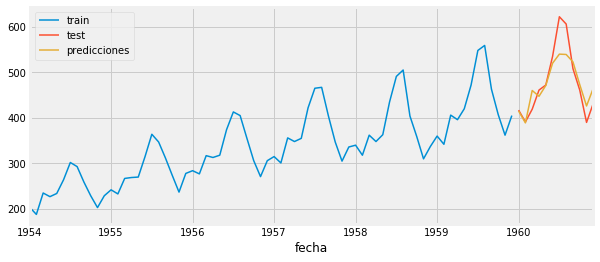

In [18]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [19]:
# Error de test
# ==============================================================================
error_mae = round(mean_absolute_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),2)

error_mape = round(mean_absolute_percentage_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ) * 100,2)

error_mse = round(mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            ),2)

print(f"Error de test (MAD): {error_mae}")
print(f"Error de test (MAPE): {error_mape} %")
#print('Error de test (MAPE) %i :' %(round(error_mape,2)))
print(f"Error de test (MSE): {error_mse}")

Error de test (MAD): 26.66
Error de test (MAPE): 5.29 %
Error de test (MSE): 1341.01


# Modelo final


Finalmente, se entrena de nuevo un ForecasterAutoreg con la configuración óptima encontrada mediante validación. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

In [20]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )

forecaster.fit(y=datos_train['y'])

In [21]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

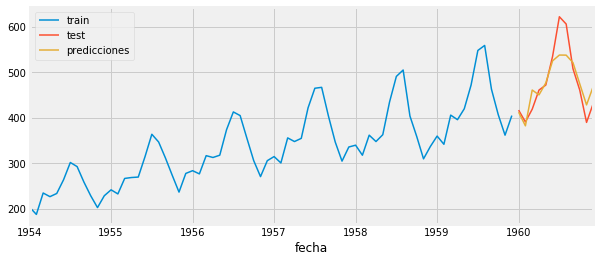

In [22]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [23]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1424.0854820833335


# Backtesting


El proceso de backtesting consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.

Backtesting con reentrenamiento

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.



In [24]:
# Backtesting
# ==============================================================================
steps = 12
n_backtesting = 12*5 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
#                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 84
Number of observations used for backtesting: 60
    Number of folds: 5
    Number of steps per fold: 12

Data partition in fold: 0
    Training:   1949-01-01 00:00:00 -- 1955-12-01 00:00:00
    Validation: 1956-01-01 00:00:00 -- 1956-12-01 00:00:00
Data partition in fold: 1
    Training:   1949-01-01 00:00:00 -- 1956-12-01 00:00:00
    Validation: 1957-01-01 00:00:00 -- 1957-12-01 00:00:00
Data partition in fold: 2
    Training:   1949-01-01 00:00:00 -- 1957-12-01 00:00:00
    Validation: 1958-01-01 00:00:00 -- 1958-12-01 00:00:00
Data partition in fold: 3
    Training:   1949-01-01 00:00:00 -- 1958-12-01 00:00:00
    Validation: 1959-01-01 00:00:00 -- 1959-12-01 00:00:00
Data partition in fold: 4
    Training:   1949-01-01 00:00:00 -- 1959-12-01 00:00:00
    Validation: 1960-01-01 00:00:00 -- 1960-12-01 00:00:00

Error de backtest: [1593.83186446]


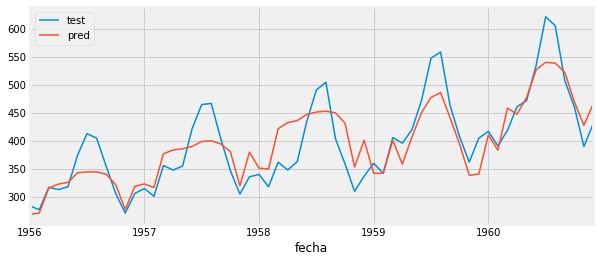

In [25]:
fig, ax = plt.subplots(figsize=(9, 4))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();